In [1]:
import glob
import re
from concurrent.futures import ThreadPoolExecutor
from glob import glob

import cv2
import numpy as np
import pandas as pd
import pydicom as dicom
from keras import Model, Input
from keras.src import backend
from keras.src import layers
from keras.src.applications import imagenet_utils
from keras.src.layers import Dense, Dropout, GlobalAveragePooling2D
from keras.src.models import Functional
from keras.src.ops import operation_utils
from keras.src.utils import file_utils
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.src.applications.densenet import DenseNet201
from keras.src.callbacks import Callback
import gc
from tensorflow.keras import backend as K
from tensorflow.python.framework import constant_op
from tensorflow.python.ops import clip_ops, math_ops
from scipy.ndimage import gaussian_filter, rotate, zoom
import albumentations as A
from collections import defaultdict
from sklearn.model_selection import KFold
import sklearn.metrics

2024-07-13 20:35:06.680532: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-13 20:35:07.544196: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
INFO:albumentations.check_version:A new version of Albumentations is available: 1.4.11 (you have 1.4.10). Upgrade using: pip install --upgrade albumentations


In [2]:
base_path = '/home/toru/PycharmProjects/rsna-2024-lumbar-spine-degenerative-classification'
train_png_file_path = f'{base_path}/train_dataset_png'

label_coordinates_df = pd.read_csv(f'{base_path}/train_label_coordinates.csv')
train_series = pd.read_csv(f'{base_path}/train_series_descriptions.csv')
df_train = pd.read_csv(f'{base_path}/train.csv')
df_sub = pd.read_csv(f'{base_path}/sample_submission.csv')
test_series = pd.read_csv(f'{base_path}/test_series_descriptions.csv')

train_dicom = f'{base_path}/train_images'
test_dicom = f'{base_path}/test_images'

model_path = f'model.keras'
model_base_path = f'.'

In [3]:
# 一つのstudy_idにseries_id が3つ未満のstudy_idを探す
study_id_list = train_series['study_id'].unique()
for study_id in study_id_list:
    series_id_list = train_series[train_series['study_id'] == study_id][
        'series_description'].unique()

    if len(series_id_list) < 3:
        print(f'study_id : {study_id}, series_id : {series_id_list}')

study_id : 2492114990, series_id : ['Axial T2' 'Sagittal T2/STIR']
study_id : 2780132468, series_id : ['Sagittal T2/STIR' 'Axial T2']
study_id : 3008676218, series_id : ['Sagittal T1' 'Axial T2']


In [4]:
# パラメータ
STUDY_NUM = 1975

# 出力のラベル
NORMAL_MILD = 0
MODERATE = 1
SEVERE = 2

# 重症度一覧
SEVERITY_LIST = ['Normal/Mild', 'Moderate', 'Severe']

# dicomデータの種類
SERIES_DESCRIPTION_LIST = train_series['series_description'].unique().tolist()
# 学習用パラメータ
BATCH_SIZE = 2
VAL_BATCH_SIZE = BATCH_SIZE * 2
EPOCHS = 1000
PATIENCE = 1 # 早期終了のパラメータ
TRAIN_RATIO = 0.95
VALID_RATIO = 0.025
TEST_RATIO = 0.025
Lr = 1e-5 * (1.0 / BATCH_SIZE)
N_FOLDS = 5 # 交差検証の分割数
SEED = 42


# 入出力の形状 (DenseNet201の入力サイズ)
INPUT_WIDTH = 512
INPUT_HEIGHT = 512
INPUT_CHANNEL_DICT = {
    'Sagittal T1': 10,
    'Sagittal T2/STIR': 10,
    'Axial T2': 10,
}
IN_CHANS = sum(INPUT_CHANNEL_DICT.values())
IMG_SIZE = [INPUT_WIDTH, INPUT_HEIGHT]

CONDITIONS = [
    'spinal_canal_stenosis',
    'left_neural_foraminal_narrowing',
    'right_neural_foraminal_narrowing',
    'left_subarticular_stenosis',
    'right_subarticular_stenosis'
]

LEVELS = [
    'l1_l2',
    'l2_l3',
    'l3_l4',
    'l4_l5',
    'l5_s1',
]

N_LABELS = 25
N_CLASSES = 3 * N_LABELS

data_filenames = ['train_data', 'valid_data', 'test_data']  # パラメータ

In [5]:
_target_name = "right_subarticular_stenosis_l5_s1"

print(f'train shape : {df_train.shape}')
print(df_train[_target_name].unique())

# それぞれの重症度の数がいくらあるか計算
print(f'Normal/Mild : {df_train[df_train[_target_name] == str("Normal/Mild")].shape[0]}')
print(f'Moderate : {df_train[df_train[_target_name] == str("Moderate")].shape[0]}')
print(f'Severe : {df_train[df_train[_target_name] == str("Severe")].shape[0]}')

print(
    f'Normal/Mild ratio : {df_train[df_train[_target_name] == str("Normal/Mild")].shape[0] / df_train.shape[0]}')
print(
    f'Moderate ratio : {df_train[df_train[_target_name] == str("Moderate")].shape[0] / df_train.shape[0]}')
print(
    f'Severe ratio : {df_train[df_train[_target_name] == str("Severe")].shape[0] / df_train.shape[0]}')


train shape : (1975, 26)
['Normal/Mild' 'Moderate' 'Severe' nan]
Normal/Mild : 1399
Moderate : 396
Severe : 173
Normal/Mild ratio : 0.7083544303797469
Moderate ratio : 0.20050632911392405
Severe ratio : 0.08759493670886076


In [15]:


def atoi(text):
    return int(text) if text.isdigit() else text


def natural_keys(text):
    return [atoi(c) for c in re.split(r'(\d+)', text)]


def get_train_label(study_id):
    """
    study_id に対応するラベルを取得 (testはデータがないのでtrainのみ)
    """

    row = df_train[df_train['study_id'] == study_id].to_numpy()[0][1:].tolist()

    row_category = np.zeros((N_LABELS, 3))
    for i in range(N_LABELS):
        if row[i] == 'Normal/Mild':
            row_category[i][0] = 1
        elif row[i] == 'Moderate':
            row_category[i][1] = 1
        elif row[i] == 'Severe':
            row_category[i][2] = 1
    # 1次元配列に変換
    row_category = row_category.flatten()
    return row_category


def get_file_list(study_id, series_desc, file_kind='train'):
    """
    study_id に対応するファイルリストを取得
    """
    dicom_file_list = []
    df = None
    if file_kind == 'train':
        df = train_series
    elif file_kind == 'test':
        df = test_series

    # study_id に対応する series_desc のリストを取得
    series_ids = df[df['study_id'] == study_id]
    series_id = series_ids[series_ids['series_description'] == series_desc]['series_id'].values
    if len(series_id) == 0:
        return dicom_file_list

    series_id = series_id[0]

    target_dicom_dir_path = ''
    if file_kind == 'train':
        target_dicom_dir_path = f'{train_dicom}/{study_id}/{series_id}/'
    elif file_kind == 'test':
        target_dicom_dir_path = f'{test_dicom}/{study_id}/{series_id}/'
    dicom_file_list = glob(target_dicom_dir_path + '/*.dcm')
    # ファイル名が数字になっているのでソート
    dicom_file_list = sorted(dicom_file_list, key=natural_keys)

    # series_desc にt対応するファイルリストを取得
    return dicom_file_list


def load_dicom_img(dicom_filepath):
    """
    dicomファイルを読み込む
    """
    dicom_data = dicom.read_file(dicom_filepath).pixel_array

    # マイナスの値があればオフセットを加える
    if np.min(dicom_data) < 0:
        dicom_data = dicom_data + np.abs(np.min(dicom_data))
    # 0-1に正規化
    dicom_data = (dicom_data - np.min(dicom_data)) / (np.max(dicom_data) - np.min(dicom_data) + 1e-6)

    # 0-255に変換
    dicom_data = dicom_data * 255

    # 512x512にリサイズ
    dicom_data = cv2.resize(dicom_data, (INPUT_WIDTH, INPUT_HEIGHT), interpolation=cv2.INTER_LINEAR)

    # uint8 に変換
    dicom_data = dicom_data.astype(np.uint8)


    return dicom_data


def select_image(image_num, selected_count):
    if selected_count <= 0:
        raise ValueError("selected_count must be greater than 0.")

    if selected_count > image_num:
        raise ValueError("selected_count cannot be greater than image_num.")

    interval = (image_num - 1) // (selected_count - 1)
    selected_numbers = list(range(1, image_num + 1, interval))

    if len(selected_numbers) > selected_count:
        selected_numbers = selected_numbers[:selected_count]

    return selected_numbers
    


def get_dicom_input_data(study_id, file_kind='train'):
    """
    study_id に対応するdicomデータを取得
    """

    input_dicom = np.zeros((INPUT_WIDTH, INPUT_HEIGHT, IN_CHANS))
    # Sagittal T1
    sagittal_t1_dicom_list = get_file_list(study_id, 'Sagittal T1', file_kind)
    if len(sagittal_t1_dicom_list) > 0 and len(sagittal_t1_dicom_list) <= 10:
        for i in range(INPUT_CHANNEL_DICT['Sagittal T1']):
            if i < len(sagittal_t1_dicom_list):
                dicom_data = load_dicom_img(sagittal_t1_dicom_list[i])
                input_dicom[:, :, i] = dicom_data
    elif len(sagittal_t1_dicom_list) > 10:
        selected_numbers = select_image(len(sagittal_t1_dicom_list), INPUT_CHANNEL_DICT['Sagittal T1'])
        for i, selected_number in enumerate(selected_numbers):
            dicom_data = load_dicom_img(sagittal_t1_dicom_list[selected_number - 1])
            input_dicom[:, :, i] = dicom_data

    # Sagittal T2/STIR
    sagittal_t2_dicom_list = get_file_list(study_id, 'Sagittal T2/STIR', file_kind)
    if len(sagittal_t2_dicom_list) > 0 and len(sagittal_t2_dicom_list) <= 10:
        for i in range(INPUT_CHANNEL_DICT['Sagittal T2/STIR']):
            if i < len(sagittal_t2_dicom_list):
                dicom_data = load_dicom_img(sagittal_t2_dicom_list[i])
                input_dicom[:, :, i + INPUT_CHANNEL_DICT['Sagittal T1']] = dicom_data 
    elif len(sagittal_t2_dicom_list) > 10:
        selected_numbers = select_image(len(sagittal_t2_dicom_list), INPUT_CHANNEL_DICT['Sagittal T2/STIR'])
        for i, selected_number in enumerate(selected_numbers):
            dicom_data = load_dicom_img(sagittal_t2_dicom_list[selected_number - 1])
            input_dicom[:, :, i + INPUT_CHANNEL_DICT['Sagittal T1']] = dicom_data

    # Axial T2
    axial_t2_dicom_list = get_file_list(study_id, 'Axial T2', file_kind)
    if len(axial_t2_dicom_list) > 0 and len(axial_t2_dicom_list) <= 10:
        for i in range(INPUT_CHANNEL_DICT['Axial T2']):
            if i < len(axial_t2_dicom_list):
                dicom_data = load_dicom_img(axial_t2_dicom_list[i])
                input_dicom[:, :, i + INPUT_CHANNEL_DICT['Sagittal T1'] + INPUT_CHANNEL_DICT[
                    'Sagittal T2/STIR']] = dicom_data
    elif len(axial_t2_dicom_list) > 10:
        selected_numbers = select_image(len(axial_t2_dicom_list), INPUT_CHANNEL_DICT['Axial T2'])
        for i, selected_number in enumerate(selected_numbers):
            dicom_data = load_dicom_img(axial_t2_dicom_list[selected_number - 1])
            input_dicom[:, :, i + INPUT_CHANNEL_DICT['Sagittal T1'] + INPUT_CHANNEL_DICT[
                'Sagittal T2/STIR']] = dicom_data
                
    # マイナスの値があればオフセットを加える
    if np.min(input_dicom) < 0:
        input_dicom = input_dicom + np.abs(np.min(input_dicom))

    # 0-1に正規化
    input_dicom = input_dicom / (np.max(input_dicom) + 1e-6)

    # 0-255に変換
    input_dicom = input_dicom * 255

    # uint8 に変換
    input_dicom = input_dicom.astype(np.uint8)

    return input_dicom

def get_dicom_and_label(study_id, file_kind):
    x_data = get_dicom_input_data(study_id, file_kind)
    y_data = get_train_label(study_id)
    return x_data, y_data

def process_one_batch(x_batch, 
                      y_batch,
                      is_augmentation=False
                      ):
    """
    一つのバッチを処理する
    """

    if is_augmentation:

        # 画像を正規化. (-があるので, offstetを加える)
        x_batch = x_batch.astype(np.float32)
        if np.min(x_batch) < 0:
            x_batch = x_batch + np.abs(np.min(x_batch))
        x_batch = x_batch / (np.max(x_batch) + 1e-6)

        for i in range(len(x_batch)):

            # 明るさを変える
            x_batch[i] = tf.image.adjust_brightness(x_batch[i], np.random.uniform(-0.5, 0.5))
            
            # ノイズを加える
            x_batch[i] = x_batch[i] + np.random.normal(0, 0.1, x_batch[i].shape)
            
            # 画像をぼかす
            # ランダムなシグマ値を生成
            sigma = np.random.uniform(-2.0, 2.0)

            # シグマ値の絶対値を取ってガウシアンブラーを適用
            x_batch[i] = gaussian_filter(x_batch[i], sigma=np.abs(sigma))

            # 特定の範囲を切り抜く (10 ~ 50)
            n_cut = np.random.randint(5, 10)
            for _ in range(n_cut):
                WINDOW_SIZE = np.random.randint(10, 100)
                x_min = np.random.randint(0, x_batch[i].shape[0] - WINDOW_SIZE)
                x_max = x_min + WINDOW_SIZE
                y_min = np.random.randint(0, x_batch[i].shape[1] - WINDOW_SIZE)
                y_max = y_min + WINDOW_SIZE
                x_batch[i][x_min:x_max, y_min:y_max] = 0

            # 画像を回転
            x_batch[i] = rotate(x_batch[i], np.random.randint(-30, 30), reshape=False)
    
            # 画像を上下, 左右にずらす, 
            x_batch[i] = np.roll(x_batch[i], np.random.randint(-10, 10), axis=0)
            x_batch[i] = np.roll(x_batch[i], np.random.randint(-10, 10), axis=1)

    # 画像を正規化. (-があるので, offstetを加える)
    x_batch = x_batch.astype(np.float32)
    if np.min(x_batch) < 0:
        x_batch = x_batch + np.abs(np.min(x_batch))
    x_batch = x_batch / (np.max(x_batch) + 1e-6)

    # (0, 255) に変換
    x_batch = x_batch * 255

    # uint8 に変換
    x_batch = x_batch.astype(np.uint8)

    return x_batch, y_batch

def shuffle_data_and_labels(x_batch, y_batch):
    # データとラベルをペアにしたリストを作成
    data_label_pairs = list(zip(x_batch, y_batch))
    # ペアのリストをシャッフル
    np.random.shuffle(data_label_pairs)
    # シャッフル後のデータとラベルをそれぞれ別々の配列に戻す
    shuffled_x_batch, shuffled_y_batch = zip(*data_label_pairs)
    # NumPy 配列に変換して返す（オプション）
    shuffled_x_batch = np.array(shuffled_x_batch)
    shuffled_y_batch = np.array(shuffled_y_batch)
    return shuffled_x_batch, shuffled_y_batch

def generator(batch_size, study_ids, file_kind='train', is_augmentation=False, is_shuffle=False):
    """
    データセットの読み込み関数
    """
    while True:
        if is_shuffle:
            np.random.shuffle(study_ids)

        for start in range(0, len(study_ids), batch_size):
            gc.collect()

            x_batch = []
            y_batch = []
            end = min(start + batch_size, len(study_ids))
            ids_train_batch = study_ids[start:end]

            with ThreadPoolExecutor() as executor:
                results = list(
                    executor.map(lambda sid: get_dicom_and_label(sid, file_kind), ids_train_batch))

            for x_data, y_data in results:
                x_batch.append(x_data)
                y_batch.append(y_data)

            x_batch = np.array(x_batch, dtype=np.float64)  # x_batch を NumPy 配列に変換
            y_batch = np.array(y_batch, dtype=np.float64)  # y_batch を NumPy 配列に変換

            x_data, y_data = process_one_batch(x_batch, y_batch, is_augmentation)

            yield x_data, y_data


def generator_load_all(batch_size, study_ids, file_kind='train', is_augmentation=False, is_shuffle=False):
    """
    実行時予めすべてのデータを読み込んだ上でデータを返す
    """
    
    x_batch = []
    y_batch = []
    print(f'事前にすべてのデータを読み込みます')

    with ThreadPoolExecutor() as executor:
        results = list(
            executor.map(lambda sid: get_dicom_and_label(sid, file_kind), study_ids))

    for x_data, y_data in results:
        x_batch.append(x_data)
        y_batch.append(y_data)

    # numpy配列に変換
    x_batch = np.array(x_batch)
    y_batch = np.array(y_batch)

    print(f'データの読み込みが完了しました')
    # データをバッチサイズに分割して返す
    while True:
        if is_shuffle:
            x_batch, y_batch = shuffle_data_and_labels(x_batch, y_batch)
        
        for start in range(0, len(x_batch), batch_size):
            end = min(start + batch_size, len(study_ids))

            x_batch_batch = x_batch[start:end]
            y_batch_batch = y_batch[start:end]

            x_batch_batch, y_batch_batch = process_one_batch(x_batch_batch, y_batch_batch, is_augmentation)

            yield np.array(x_batch_batch), np.array(y_batch_batch)
    

def generate_and_save_data(study_ids, file_name, file_kind='train'):
    """
    学習用データを生成して保存
    """
    x_batch = []
    y_batch = []
    for sid in study_ids:
        print(f'残りのデータ数 : {len(study_ids) - len(x_batch)}')
        x_data, y_data = get_dicom_and_label(sid, file_kind)
        x_batch.append(x_data)
        y_batch.append(y_data)

    x_batch = np.array(x_batch)
    y_batch = np.array(y_batch)

    print(f'x_batch shape : {x_batch.shape}')
    print(f'y_batch shape : {y_batch.shape}')

    np.save(f'{file_name}_x.npy', x_batch)
    np.save(f'{file_name}_y.npy', y_batch)

    # メモリ解放
    del x_batch
    del y_batch
    gc.collect()


def save_train_data():
    """
    学習用データを保存
    """
    train_study_ids = get_train_study_id_array()
    generate_and_save_data(train_study_ids, file_name='train_data', file_kind='train')


def save_valid_data():
    """
    検証用データを保存
    """
    valid_study_ids = get_valid_study_id_array()
    generate_and_save_data(valid_study_ids, file_name='valid_data', file_kind='train')


def save_test_data():
    """
    テスト用データを保存
    """
    test_study_ids = get_test_study_id_array()
    generate_and_save_data(test_study_ids, file_name='test_data', file_kind='train')


# 学習用データの study_id を取得
def get_train_study_id_array():
    _study_ids = train_series['study_id'].unique()

    # 0.8 で分割
    train_study_ids = _study_ids[:int(len(_study_ids) * 0.8)]
    return train_study_ids


# 検証用データの study_id を取得
def get_valid_study_id_array():
    _study_ids = train_series['study_id'].unique()

    # 0.8 で分割
    valid_study_ids = _study_ids[int(len(_study_ids) * 0.8):int(len(_study_ids) * 0.9)]
    return valid_study_ids


# テスト用データの study_id を取得 (実際のテストデータではなく, 学習データの一部をテストデータとして使用)
def get_test_study_id_array():
    _study_ids = train_series['study_id'].unique()
    # 0.8 で分割
    test_study_ids = _study_ids[int(len(_study_ids) * 0.9):]
    return test_study_ids


def generator_for_test(batch_size, study_ids, file_kind='test'):
    """
    test_seriesからテスト用のデータセット作成
    kaggle で提出時に呼び出される
    :param batch_size: 
    :param study_ids: 
    :return: 
    """
    for start in range(0, len(study_ids), batch_size):
        x_batch = []
        end = min(start + batch_size, len(study_ids))
        ids_train_batch = study_ids[start:end]

        for sid in ids_train_batch:
            dicom_img = get_dicom_input_data(sid, file_kind)

            x_batch.append(dicom_img)


        yield np.array(x_batch), ids_train_batch


def generate_and_save_data(study_ids, file_name, file_kind='train'):
    """
    学習用データを生成して保存
    """
    x_batch = []
    y_batch = []
    for sid in study_ids:
        print(f'残りのデータ数 : {len(study_ids) - len(x_batch)}')
        x_data, y_data = get_dicom_and_label(sid, file_kind)
        x_batch.append(x_data)
        y_batch.append(y_data)

    x_batch = np.array(x_batch)
    y_batch = np.array(y_batch)

    print(f'x_batch shape : {x_batch.shape}')
    print(f'y_batch shape : {y_batch.shape}')

    np.save(f'{file_name}_x.npy', x_batch)
    np.save(f'{file_name}_y.npy', y_batch)

    # メモリ解放
    del x_batch
    del y_batch
    gc.collect()


def load_data(file_name):
    """
    データを読み込む
    """
    x_data = np.load(f'{file_name}_x.npy')
    y_data = np.load(f'{file_name}_y.npy')

    return x_data, y_data



def generator_with_load_data(batch_size,
                             file_name,
                             file_kind='train',
                             is_augmentation=False,
                             is_shuffle=False,
                             is_only_one_epoch=False):
    """
    事前にデータを読み込んでデータを返す
    """
    x_batch, y_batch = load_data(file_name)

    def shuffle_data_and_labels(x_batch, y_batch):
        # データとラベルをペアにしたリストを作成
        data_label_pairs = list(zip(x_batch, y_batch))

        # ペアのリストをシャッフル
        np.random.shuffle(data_label_pairs)

        # シャッフル後のデータとラベルをそれぞれ別々の配列に戻す
        shuffled_x_batch, shuffled_y_batch = zip(*data_label_pairs)

        # NumPy 配列に変換して返す（オプション）
        shuffled_x_batch = np.array(shuffled_x_batch)
        shuffled_y_batch = np.array(shuffled_y_batch)

        return shuffled_x_batch, shuffled_y_batch
    
    studyid_len = x_batch.shape[0]

    while True:
        # epochごとにシャッフル
        if is_shuffle:
            x_batch, y_batch = shuffle_data_and_labels(x_batch, y_batch)

        for start in range(0, len(x_batch), batch_size):
            end = min(start + batch_size, studyid_len)

            x_batch_batch = x_batch[start:end]
            y_batch_batch = y_batch[start:end]

            x_batch_batch, y_batch_batch = process_one_batch(x_batch_batch, y_batch_batch, is_augmentation)
            
            yield np.array(x_batch_batch), np.array(y_batch_batch)

        if is_only_one_epoch:
            break

    # メモリ解放
    del x_batch
    del y_batch
    gc.collect()

def get_severity_rate(study_id):
    """
    study_id に対応する重症度の割合を取得
    """
    row = df_train[df_train['study_id'] == study_id].to_numpy()[0][1:].tolist()

    # それぞれの重症度の数がいくらあるか計算
    normal_mild = row.count('Normal/Mild')
    moderate = row.count('Moderate')
    severe = row.count('Severe')

    # 重症度の割合を計算
    normal_mild_rate = normal_mild / len(row)
    moderate_rate = moderate / len(row)
    severe_rate = severe / len(row)

    return normal_mild_rate, moderate_rate, severe_rate

def get_separated_studyid_lists():
    """
    学習用に分割されたデータセットを取得する.
    戻り値は, train, valid, test の3つのリスト
    データの中の割合が 8:1:1 になるように分割する
    重症度が均等に分布するようにデータを分割する
    データセットには Normal/Mild, Moderate, Severe の3つの重症度がある
    数としては Normal/Mild > Moderate > Severe となる
    """
    study_ids = train_series['study_id'].unique()

    # それぞれの重症度の数がいくらあるか計算
    severity_rates = defaultdict(list)
    for study_id in study_ids:
        normal_mild_rate, moderate_rate, severe_rate = get_severity_rate(study_id)
        severity_rates['Normal/Mild'].append(normal_mild_rate)
        severity_rates['Moderate'].append(moderate_rate)
        severity_rates['Severe'].append(severe_rate)

    # 各リストをnumpy配列に変換
    for key in severity_rates:
        severity_rates[key] = np.array(severity_rates[key])

    # 重症度の割合が均等になるようにstudy_idを分割
    sorted_study_ids = sorted(study_ids, key=lambda x: (
        severity_rates['Severe'][list(study_ids).index(x)],
        severity_rates['Moderate'][list(study_ids).index(x)],
        severity_rates['Normal/Mild'][list(study_ids).index(x)],
    ))

    # study_idをtrain, valid, testに分割
    total_samples = len(sorted_study_ids)
    train_end = int(total_samples * TRAIN_RATIO)
    valid_end = int(total_samples * (TRAIN_RATIO + VALID_RATIO))

    train_study_ids = []
    valid_study_ids = []
    test_study_ids = []

    # 割合に応じで順番にデータを分割
    for i, study_id in enumerate(sorted_study_ids):
        # 0 ~ 1.0 の乱数を生成
        while True:
            rand = np.random.rand()

            if rand < TRAIN_RATIO:
                if len(train_study_ids) < train_end:
                    train_study_ids.append(study_id)
                    break
            elif rand < TRAIN_RATIO + VALID_RATIO:
                if len(valid_study_ids) < valid_end - train_end:
                    valid_study_ids.append(study_id)
                    break
            else:
                if len(test_study_ids) < total_samples - valid_end:
                    test_study_ids.append(study_id)
                    break


    return train_study_ids, valid_study_ids, test_study_ids

In [7]:
# 2492114990
for desc in SERIES_DESCRIPTION_LIST:
    dicom_image_list = get_file_list(2492114990, desc)
    print(f'{desc} : {len(dicom_image_list)}')

Sagittal T2/STIR : 18
Sagittal T1 : 0
Axial T2 : 53


In [8]:
# study_id のリストを作成
train_study_ids, valid_study_ids, test_study_ids = get_separated_studyid_lists()

print(f'train_study_ids : {len(train_study_ids)}')
print(f'valid_study_ids : {len(valid_study_ids)}')
print(f'test_study_ids : {len(test_study_ids)}')

train_study_ids : 1876
valid_study_ids : 49
test_study_ids : 50


2024-07-13 20:35:11.875674: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-13 20:35:12.022172: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-13 20:35:12.024467: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

x_batch shape : (2, 512, 512, 30)
y_batch shape : (2, 75)
sid : [1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.
 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0.
 1. 0. 0.]


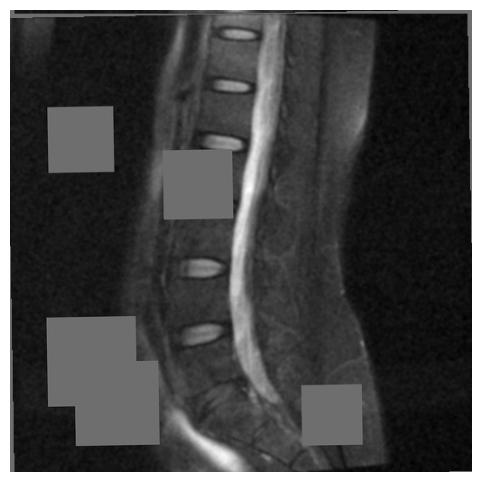

sid : [1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0.
 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0.
 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0.
 1. 0. 0.]


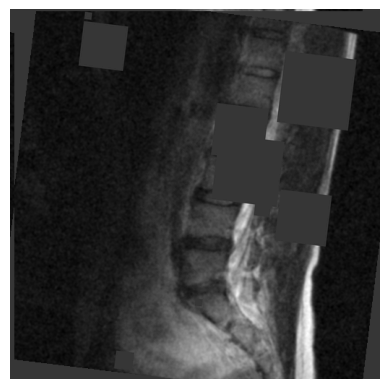

In [9]:
# generator のテスト
for x_batch, y_batch in generator(BATCH_SIZE, train_study_ids, is_augmentation=True):
    
    print(f'x_batch shape : {x_batch.shape}')
    print(f'y_batch shape : {y_batch.shape}')

    # 画像を表示
    plt.figure(figsize=(6, 6))
    for i in range(BATCH_SIZE):
        print(f'sid : {y_batch[i]}')
        plt.imshow(x_batch[i, :, :, 17], cmap='gray')
        plt.axis('off')
        plt.show()
    break

x_batch shape : (1, 512, 512, 30)
study_ids : [44036939]
max value : 254
min value : 0


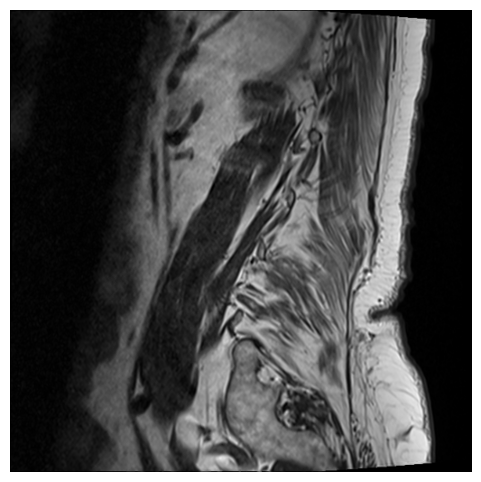

In [10]:
# generator_for_test を使ってテストデータを読み込む
test_dataset_ids = test_series['study_id'].unique()
for x_batch, study_ids in generator_for_test(BATCH_SIZE, test_dataset_ids):
    print(f'x_batch shape : {x_batch.shape}')
    print(f'study_ids : {study_ids}')
    print(f'max value : {np.max(x_batch)}')
    print(f'min value : {np.min(x_batch)}')

    # 画像を表示
    plt.figure(figsize=(6, 6))
    for i in range(1):
        plt.imshow(x_batch[i, :, :, 0], cmap='gray')
        plt.axis('off')
    plt.show()
    break

In [47]:
def total_acc(y_true, y_pred):
    pred = tf.dtypes.cast(tf.math.greater(y_pred, 0.5), tf.float64)
    flag = tf.dtypes.cast(tf.math.equal(y_true, pred), tf.float64)
    return tf.reduce_prod(flag, axis=-1)


def binary_acc(y_true, y_pred):
    pred = tf.dtypes.cast(tf.math.greater(y_pred, 0.5), tf.float64)
    flag = tf.dtypes.cast(tf.math.equal(y_true, pred), tf.float64)
    return tf.reduce_mean(flag, axis=-1)

def log_loss_metrics(y_true, y_pred):
    # target を output の型にキャスト
    y_true = tf.dtypes.cast(y_true, y_pred.dtype)
    epsilon_ = constant_op.constant(0.00001, y_pred.dtype)
    loss_weight = tf.constant(np.array([1, 2, 4] * 25), y_pred.dtype)

    # nan を防ぐためにクリップ
    y_pred = clip_ops.clip_by_value(y_pred, epsilon_, 0.99999)

    # output を (None, 25, 3) に変換
    y_pred = tf.reshape(y_pred, (-1, 25, 3))
    
    # 各行ごとにsoftmaxを適用
    y_pred = tf.nn.softmax(y_pred, axis=-1)

    # (75, ) に変換
    y_pred = tf.reshape(y_pred, (-1, 75))

    # 交差エントロピーの計算
    bce = y_true * math_ops.log(y_pred + epsilon_) * loss_weight
    bce += (1.0 - y_true) * math_ops.log(1.0 - y_pred + epsilon_)
    
    # 交差エントロピーの正規化
    bce_avg = K.mean(-bce, axis=-1)
    return bce_avg

def binary_crossentropy_balance(target, output):
    # target を output の型にキャスト
    target = tf.dtypes.cast(target, output.dtype)
    epsilon_ = constant_op.constant(0.00001, output.dtype)
    loss_weight = tf.constant(np.array([1, 2, 4] * 25), output.dtype)

    # nan を防ぐためにクリップ
    output = clip_ops.clip_by_value(output, epsilon_, 0.99999)

    # output を (None, 25, 3) に変換
    output = tf.reshape(output, (-1, 25, 3))
    
    # 各行ごとにsoftmaxを適用
    output = tf.nn.softmax(output, axis=-1)

    # (75, ) に変換
    output = tf.reshape(output, (-1, 75))


    # 交差エントロピーの計算
    bce = target * math_ops.log(output + epsilon_) * loss_weight
    bce += (1.0 - target) * math_ops.log(1.0 - output + epsilon_)

    bce_sum = -K.sum(bce, axis=-1)
    return bce_sum


def create_model(model_name='DenseNet201'):
    # カスタム入力層
    input_shape = (INPUT_WIDTH, INPUT_HEIGHT, IN_CHANS)
    inputs = Input(shape=input_shape)

    x = inputs

    # Conv2D (None, 512, 512, IN_CHAINS) -> (None, 512, 512, IN_CHAINS)
    x = Conv2D(3, (1, 1), activation='linear')(x)

    # DenseNet201
    base_model = tf.keras.applications.DenseNet201(
        include_top=True,
        weights=None,
        input_tensor=x,
        input_shape=(INPUT_WIDTH, INPUT_HEIGHT, IN_CHANS),
        pooling=None,
        classes=N_CLASSES,
        classifier_activation='sigmoid',
    )

    # ベースモデルの出力
    x = base_model.output

    # Dropout
    x = Dropout(0.2)(x)

    # モデルの作成
    model = Model(inputs=inputs, outputs=x, name=model_name)

    # optimizer : Adam
    opt = tf.keras.optimizers.AdamW(learning_rate=Lr)

    # モデルのコンパイル
    model.compile(optimizer=opt,
                  loss=binary_crossentropy_balance,
                  metrics=[binary_acc, total_acc, log_loss_metrics])

    return model

In [12]:
from keras.src.callbacks import EarlyStopping


class CustomCheckpoint(Callback):
    def __init__(self, filepath):
        super(CustomCheckpoint, self).__init__()
        self.filepath = filepath
        self.best_val_accuracy = 1.0

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        val_log_loss_metrics = logs.get('val_log_loss_metrics')

        if val_log_loss_metrics is not None and val_log_loss_metrics < self.best_val_accuracy and val_log_loss_metrics < 0.8:
            self.best_val_accuracy = val_log_loss_metrics
            filepath = f'{self.filepath}.keras'
            self.model.save(filepath, overwrite=True)
            print(f'Saved model to {filepath} with validation accuracy: {val_log_loss_metrics:.4f}')


# カスタムチェックポイントのコールバックを作成
custom_checkpoint = CustomCheckpoint(filepath='model_dense')
Ecall = EarlyStopping(monitor='val_loss', patience=PATIENCE, restore_best_weights=True)

In [ ]:
# すべてのstudy_idを取得
study_ids = train_series['study_id'].unique()
skf = KFold(n_splits=N_FOLDS, shuffle=True, random_state=SEED)
for fold, (train_index, valid_index) in enumerate(skf.split(study_ids)):
    print(f'fold : {fold + 1}')

    train_study_ids = study_ids[train_index]
    valid_study_ids = study_ids[valid_index]

    train_file_name = f'train_data_{fold}'
    valid_file_name = f'valid_data_{fold}'

    custom_checkpoint = CustomCheckpoint(filepath=f'model_dense_{fold + 1}')
    model = create_model(model_name=f'DenseNet201_{fold + 1}')


    history = model.fit(
        generator_with_load_data(BATCH_SIZE, train_file_name, is_augmentation=True, is_shuffle=True),
        steps_per_epoch=len(train_study_ids) // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=generator_with_load_data(VAL_BATCH_SIZE, valid_file_name, is_augmentation=False, is_shuffle=False),
        validation_steps=len(valid_study_ids) // VAL_BATCH_SIZE,
        callbacks=[custom_checkpoint, Ecall]
    )

    # メモリ解放
    del model
    del history
    del custom_checkpoint
    del train_study_ids
    del valid_study_ids
    tf.keras.backend.clear_session()
    gc.collect()

In [13]:
models = []

for i in range(N_FOLDS):
    print(f'Loading model fold {i + 1}')
    model = create_model()
    model.load_weights(f'{model_base_path}/model_dense_{i + 1}.keras')
    models.append(model)


Loading model fold 1


/home/toru/PycharmProjects/til/venv/lib/python3.10/site-packages/keras/src/applications/densenet.py:206: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 30 input channels.
  input_shape = imagenet_utils.obtain_input_shape(
/home/toru/PycharmProjects/til/venv/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adamw', because it has 2 variables whereas the saved optimizer has 1210 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Loading model fold 2
Loading model fold 3
Loading model fold 4
Loading model fold 5


In [43]:
test_dataset_ids = test_series['study_id'].unique()
# test_dataset_ids = train_series['study_id'].unique()[:10]
sub = pd.DataFrame()
submission_labels = ['normal_mild', 'moderate', 'severe']

y_preds = []
row_names = []

print(f'len(test_dataset_ids) : {test_dataset_ids}')

# テストデータの予測
for x, sids in generator_for_test(VAL_BATCH_SIZE, test_dataset_ids, file_kind='test'):
    print(f'sids : {sids}')

    y_pred_batch = []
    for i in range(N_FOLDS):
        y_pred = models[i].predict(x)
        y_pred_batch.append(y_pred)

    y_pred = np.mean(y_pred_batch, axis=0)

    # (None, 25, 3) に変換
    y_pred = np.reshape(y_pred, (-1, 3))

    # softmax を適用
    y_pred = tf.nn.softmax(y_pred, axis=-1)

    # 小数点第4位まで四捨五入
    y_pred = np.round(y_pred, 6)


    # rowの名前を作成　
    for sid in sids:
        for condition in CONDITIONS:
            for level in LEVELS:
                row_names.append(f'{sid}_{condition}_{level}')

    for i in range(y_pred.shape[0]):
        y_preds.append(y_pred[i]) 

    del x, y_pred
    gc.collect()

y_preds = np.array(y_preds)

# pdに追加
sub['row_id'] = row_names
sub[submission_labels] = y_preds

len(test_dataset_ids) : [44036939]
sids : [44036939]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


In [44]:
sub.to_csv('submission.csv', index=False)

In [45]:
sub

,row_id,normal_mild,moderate,severe
0,44036939_spinal_canal_stenosis_l1_l2,0.574998,0.211814,0.213188
1,44036939_spinal_canal_stenosis_l2_l3,0.572009,0.215925,0.212066
2,44036939_spinal_canal_stenosis_l3_l4,0.550167,0.222040,0.227793
3,44036939_spinal_canal_stenosis_l4_l5,0.563820,0.215293,0.220887
4,44036939_spinal_canal_stenosis_l5_s1,0.575794,0.212043,0.212163
5,44036939_left_neural_foraminal_narrowing_l1_l2,0.574600,0.213705,0.211695
6,44036939_left_neural_foraminal_narrowing_l2_l3,0.573367,0.214414,0.212219
7,44036939_left_neural_foraminal_narrowing_l3_l4,0.558975,0.233360,0.207665
8,44036939_left_neural_foraminal_narrowing_l4_l5,0.489249,0.266199,0.244552
9,44036939_left_neural_foraminal_narrowing_l5_s1,0.493401,0.283955,0.222644
